In [132]:
#k最近傍法（2018年12月〜2019年6月中旬までの糖度を予測）

In [133]:
%matplotlib inline
import sys
sys.path.append('/home/yoshida/.pyenv/versions/3.6.6/lib/python3.6/site-packages')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [134]:
# データの読み込み
data = pd.read_csv("../src/Aiko_normalization_ver3_aaa.csv")
df = pd.DataFrame(data)

In [135]:
df.drop(['No','current_date','width','height','seed_date','house','url', 'COL_21'], axis=1, inplace=True) #対象の列を削除

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 13 columns):
sweet             2176 non-null float64
sweet_category    2176 non-null int64
size              2176 non-null float64
AveCO2_7          2176 non-null float64
AveSatu_7         2176 non-null float64
AveHum_7          2176 non-null float64
AveTemp_7         2176 non-null float64
AveMaxTemp_7      2176 non-null float64
AveMinTemp_7      2176 non-null float64
AveDiffTemp_7     2176 non-null float64
SumMaxTemp_7      2176 non-null float64
SumMinTemp_7      2176 non-null float64
SumDiffTemp_7     2176 non-null float64
dtypes: float64(12), int64(1)
memory usage: 221.1 KB


In [137]:
# AveDiffTemp_7、AveSatu_7、monthを対象としたい時
#df.drop(['AveCO2_7', 'AveSatu_7', 'AveTemp_7', 'AveHum_7', 'AveMinTemp_7', 'AveDiffTemp_7', 'SumMaxTemp_7','SumMinTemp_7','SumDiffTemp_7'], axis=1, inplace=True)

In [138]:
df.head()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
0,4.3,2,7.54,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
1,4.5,2,6.48,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
2,4.0,1,8.68,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
3,3.5,1,10.50,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
4,4.3,2,7.00,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9


In [139]:
#  <-----------------------------------------
df.drop(['AveHum_7', 'AveMaxTemp_7', 'SumDiffTemp_7', 'AveMinTemp_7', 'SumMaxTemp_7', 'SumMinTemp_7', 'AveTemp_7'], axis=1, inplace=True) #対象の列を削除

In [95]:
df.head()

,sweet,sweet_category,size,AveCO2_7,AveMaxTemp_7,AveDiffTemp_7
0,4.3,2,7.54,614.28,26.24,7.41
1,4.5,2,6.48,614.28,26.24,7.41
2,4.0,1,8.68,614.28,26.24,7.41
3,3.5,1,10.50,614.28,26.24,7.41
4,4.3,2,7.00,614.28,26.24,7.41


In [10]:
df['month'] = df['current_date'].str[:2] # "11月28日"とか"4月3日"の月日の先頭2文字だけ抽出
df['month'] = df['month'].str.strip('月') # このままだと"4月"のように"月"が入っているので、"月"を削除する
# 参考：https://deepage.net/features/pandas-str-extract.html
# 参考：https://deepage.net/features/pandas-str-replace.html
df['month'].isnull().sum() # 欠損値がないかを確認

df.drop(['current_date'], axis=1, inplace=True) # current_dateはもう使わない
print(df.shape)

(2176, 6)


In [11]:
# 四半期を求める(4~6月:1st、7~9月:2nd、10~12月:3rd、1~3月:4th)(＊＊＊＊使うか使わないか＊＊＊＊)
df['quarter'] = df['month'].replace({'4': '1st', '5': '1st', '6': '1st', 
                                     '7': '2nd', '8': '2nd', '9': '2nd', 
                                     '10': '3rd', '11': '3rd', '12': '3rd', 
                                     '1': '4th', '2': '4th', '3': '4th'
                                    })

In [12]:
# ダミー変数の作成
df = pd.get_dummies(df, columns=['quarter'], drop_first=True)

In [13]:
df.drop(['month'], axis=1, inplace=True)

In [140]:
df.head()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveDiffTemp_7
0,4.3,2,7.54,614.28,6.17,7.41
1,4.5,2,6.48,614.28,6.17,7.41
2,4.0,1,8.68,614.28,6.17,7.41
3,3.5,1,10.50,614.28,6.17,7.41
4,4.3,2,7.00,614.28,6.17,7.41


In [141]:
df['sweet_category'] = df['sweet_category'].replace({1: 1, 2: 1000, 3: 10000, 4: 20000})

In [142]:
# 四分位数
def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns
    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        # 四分位範囲
        iqr = q3 - q1
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5
        # 範囲から外れている値を除く
        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
    return df

In [143]:
print("before", df.shape)
df = outlier_iqr(df, ['sweet'])
print("after", df.shape)

before (2176, 6)
after (2173, 6)


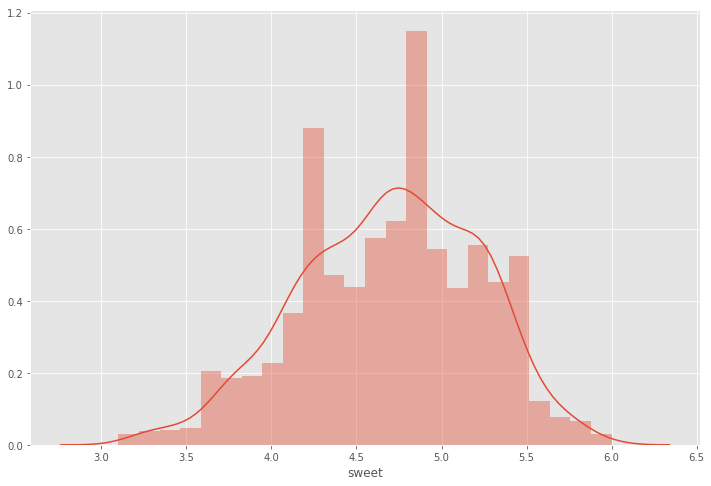

In [144]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df['sweet'])

In [145]:
#  <-----------------------------------------

#df['size_2'] = df['size']**2
df['size_3'] = df['size']**3
#df['AveHum_7_2'] = df['AveHum_7']**2.5
#df['AveMaxTemp_7_2'] = df['AveMaxTemp_7']**2.5
#df['AveMinTemp_7_2'] = df['AveMinTemp_7']**2
#df['AveDiffTemp_7_2'] = df['AveDiffTemp_7']**2
df['AveDiffTemp_7_3'] = df['AveDiffTemp_7']**3
#df['SumDiffTemp_7_2'] = df['SumDiffTemp_7']**2
#df['AveTemp_7_3'] = df['AveTemp_7']**2
df['AveSatu_7_3'] = df['AveSatu_7']**3
#df['SumMaxTemp_7_2'] = df['SumMaxTemp_7']**2
#df['SumMinTemp_7_2'] = df['SumMinTemp_7']**2
#df['SumAveTemp_7_2'] = df['SumAveTemp_7']**2
df['AveCO2_7_1.5'] = df['AveCO2_7']**1.5


In [146]:
df.head()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveDiffTemp_7,size_3,AveDiffTemp_7_3,AveSatu_7_3,AveCO2_7_1.5
0,4.3,1000,7.54,614.28,6.17,7.41,428.661064,406.869021,234.885113,15224.728736
1,4.5,1000,6.48,614.28,6.17,7.41,272.097792,406.869021,234.885113,15224.728736
2,4.0,1,8.68,614.28,6.17,7.41,653.972032,406.869021,234.885113,15224.728736
3,3.5,1,10.50,614.28,6.17,7.41,1157.625000,406.869021,234.885113,15224.728736
4,4.3,1000,7.00,614.28,6.17,7.41,343.000000,406.869021,234.885113,15224.728736


In [147]:
df.drop(['size','AveCO2_7', 'AveDiffTemp_7', 'AveSatu_7'], axis=1, inplace=True) #対象の列を削除  <-----------------------------------------

y = df["sweet_category"] #目的変数
df.drop(['sweet', 'sweet_category'], axis=1, inplace=True) #目的変数の列を削除

In [148]:
df.head()

,size_3,AveDiffTemp_7_3,AveSatu_7_3,AveCO2_7_1.5
0,428.661064,406.869021,234.885113,15224.728736
1,272.097792,406.869021,234.885113,15224.728736
2,653.972032,406.869021,234.885113,15224.728736
3,1157.625000,406.869021,234.885113,15224.728736
4,343.000000,406.869021,234.885113,15224.728736


In [149]:
# 検証データとテストデータに分割
#stratify は母集団のカテゴリの割合を保って分割するもので、目的変数を指定するのが一般的
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(df, y, test_size=0.3, random_state=0, stratify=y)

In [150]:
# ハイパーパラメータを辞書型
params_grid = {'weights': ['uniform', 'distance'], 'n_neighbors':[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]}

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [152]:
grid_search = GridSearchCV(KNeighborsClassifier(), params_grid, scoring="accuracy",cv=10, n_jobs=-1)# 上記で用意したパラメーターごとに交差検証を実施

In [153]:
grid_search.fit(X_trainval, y_trainval) # 学習

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [154]:
# グリッドサーチの結果
print('Best cross-validation: {}'.format(round(grid_search.best_score_, 3)))
print('Best parameters : {}'.format(grid_search.best_params_))

Best cross-validation: 0.757
Best parameters : {'n_neighbors': 4, 'weights': 'uniform'}


In [155]:
print('Test set score : {}'.format(round(grid_search.score(X_test, y_test), 3)))

Test set score : 0.779


In [156]:
# 多クラス混合行列
from sklearn.metrics import confusion_matrix
clf = grid_search.best_estimator_
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))

[[ 60  16   0   0]
 [ 19 117  34   0]
 [  1  26 182  19]
 [  0   0  29 149]]
